# auditor - introduction into model audit

The diagnostic analysis is well researched and commonly used to validate linear models, while it is often neglected for complex black-box models. 

This notebook is a gentle introduction to the `auditor` package which is a uniform interface to statistics and visualizations that facilitate assessing and comparing the goodness of fit, performance, diagnostic and similarity of any model. 

For more detailed descriptions of the methodology and functionalities see [auditor webpage](https://mi2-warsaw.github.io/auditor/index.html).

## Regression use case - dragons data

To illustrate applications of auditor to regression problems we will use an artificial dataset dragons available in the `auditor` package. Our goal is to predict length of life of each dragon. The prediction will be based on 4 variables: `colour`, `height`, `herd.size` and `teeth.len`.

In [3]:
library("auditor")
data(dragons)
data(dragons_test)

In [4]:
head(dragons)

teeth.len,colour,height,herd.size,life.len
3.20,red,48.99,4,2467
1.71,blue,31.97,4,1550
0.67,green,59.78,2,2931
7.47,green,91.46,1,5407
0.55,red,14.62,1,985
2.54,green,98.17,1,4870


## Models

We fit two models: linear regression and a single decision tree

In [5]:
lm_model <- lm(life.len ~ height + colour + herd.size + teeth.len, data=dragons)

library("rpart")
set.seed(59)
tree_model <- rpart(life.len ~ height + colour + herd.size + teeth.len, data=dragons)

## Preparation for error analysis

The beginning of each analysis is creation of a `modelAudit` object which contains metadata required for further analysis.

In [6]:
lm_audit <- audit(lm_model, label = "lm", data = dragons_test, y = dragons_test$life.len)
tree_audit <- audit(tree_model, label = "tree", data = dragons_test, y = dragons_test$life.len)

## Model performance

The model performance can be checked on several scores. We can see on the plot below that both models perform similar with only small differences on each score.

In [9]:
lm_mp <- modelPerformance(lm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
tree_mp <- modelPerformance(tree_audit, scores = c("MAE", "MSE", "REC", "RROC"))

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


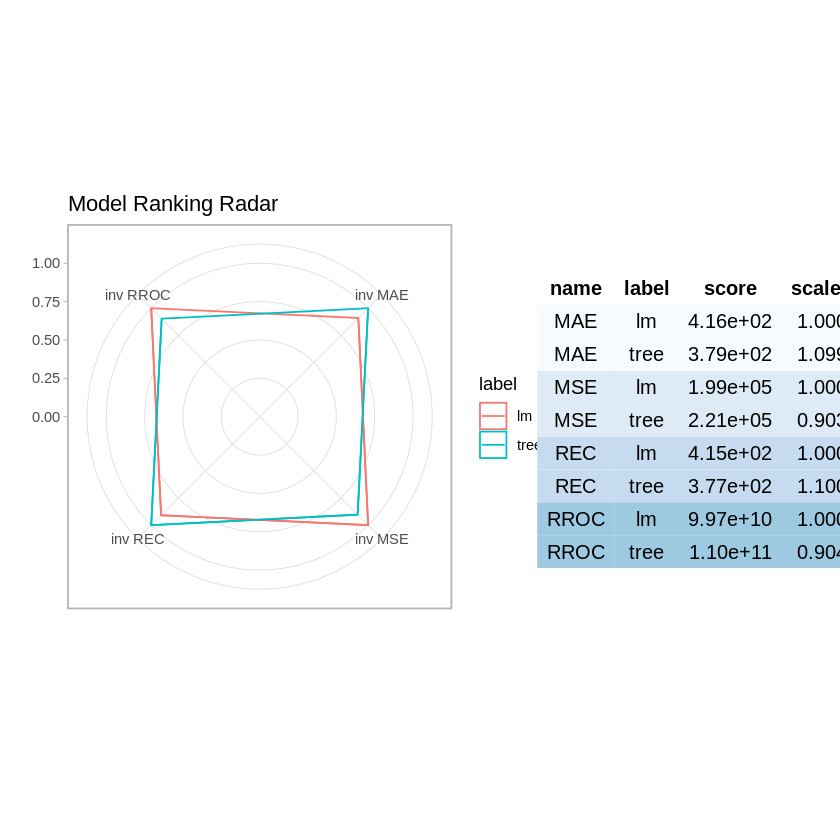

In [10]:
plot(lm_mp, tree_mp, table = TRUE)

## Plotting residuals

Function `plot` used on `modelResiduals` object returns a Residuals vs some variable plot. Here we plot Residuals against ground truth.

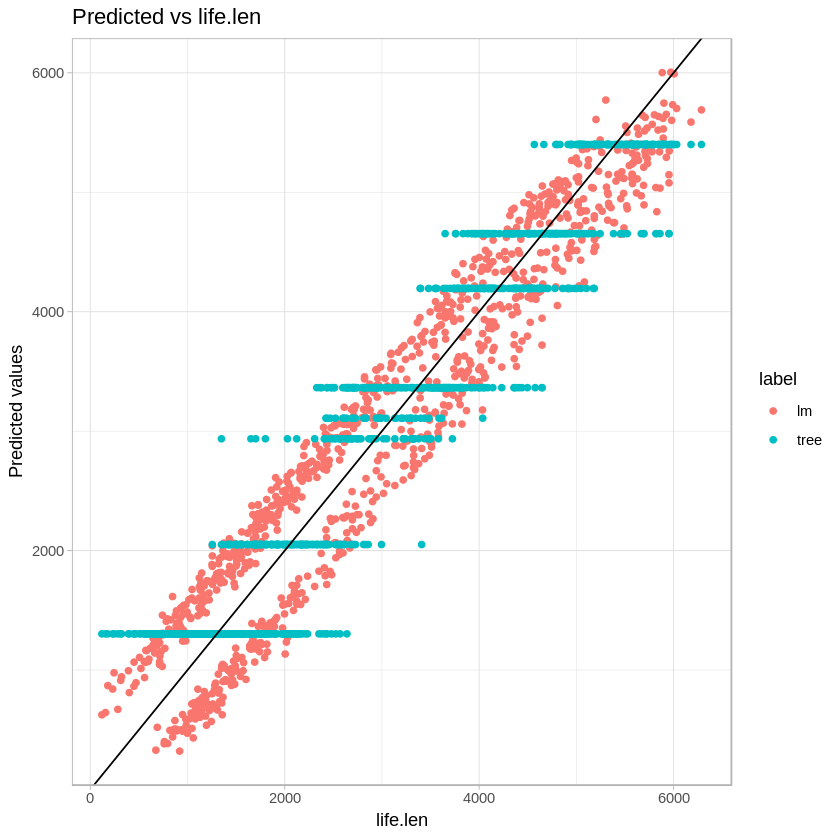

In [11]:
lm_mr_m2 <- modelResiduals(lm_audit, variable = "life.len")
tree_mr_m2 <- modelResiduals(tree_audit, variable = "life.len")

plot(lm_mr_m2, tree_mr_m2, type = "Prediction")

Looks strange. The Residuals for linear model form two different groups. The `residualDensity` plot below shows it even better.

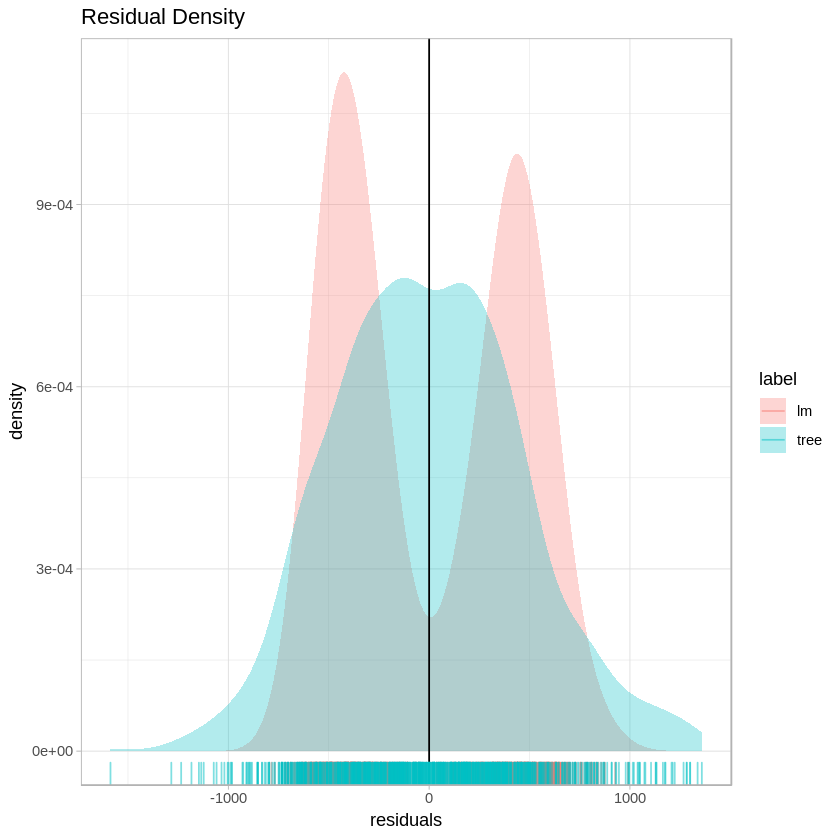

In [12]:
plotResidualDensity(lm_audit, tree_audit)

Looks like we have two groups of observations. Let's check out the residuals vs each variable to see if any correlation it's visible there.

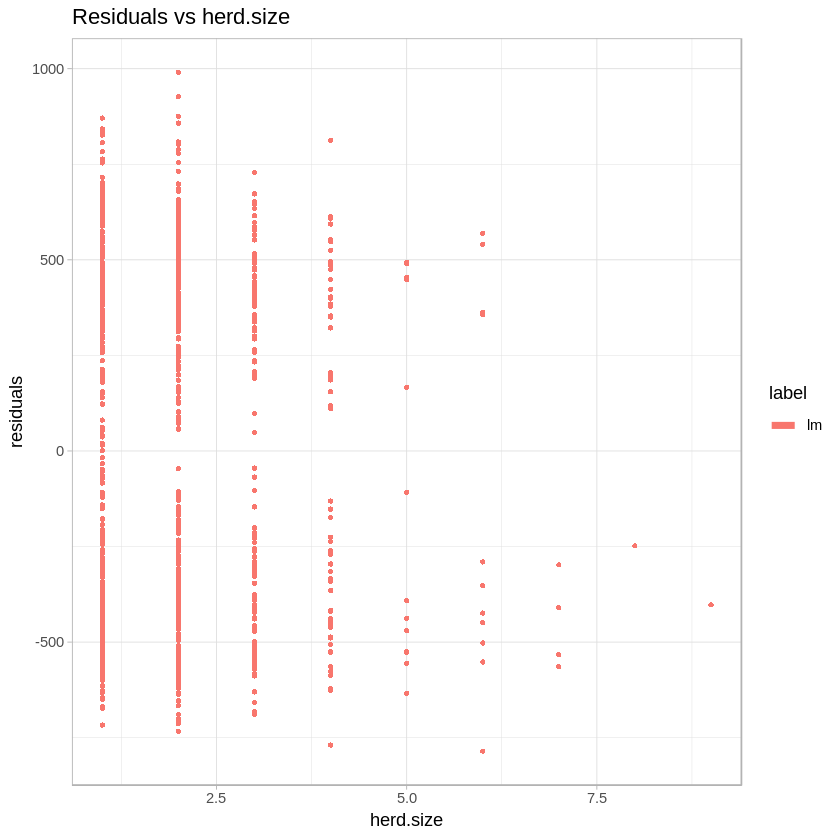

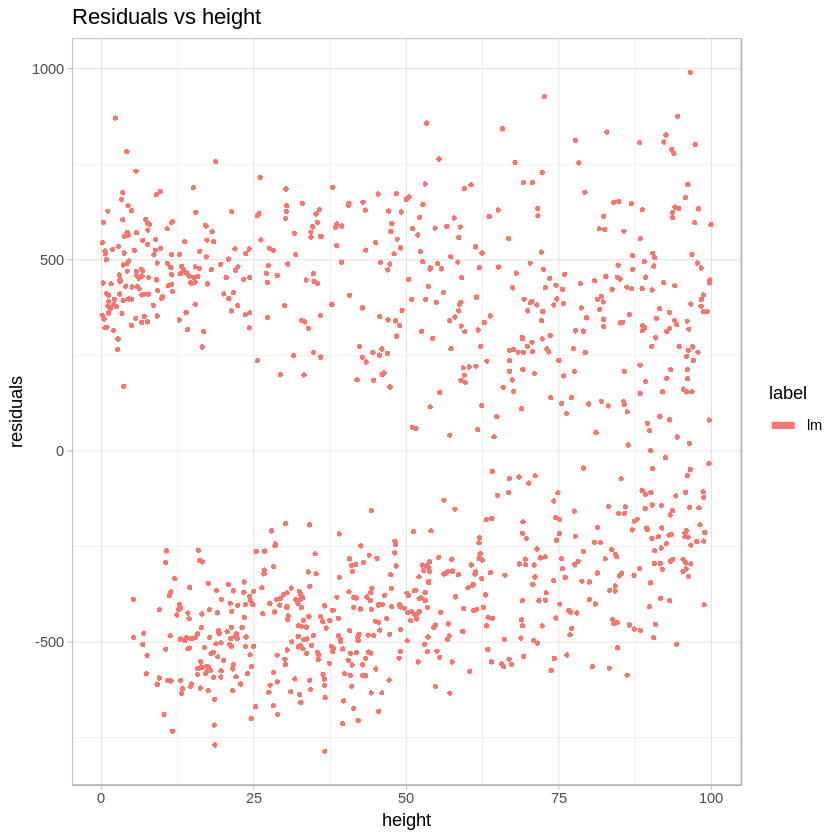

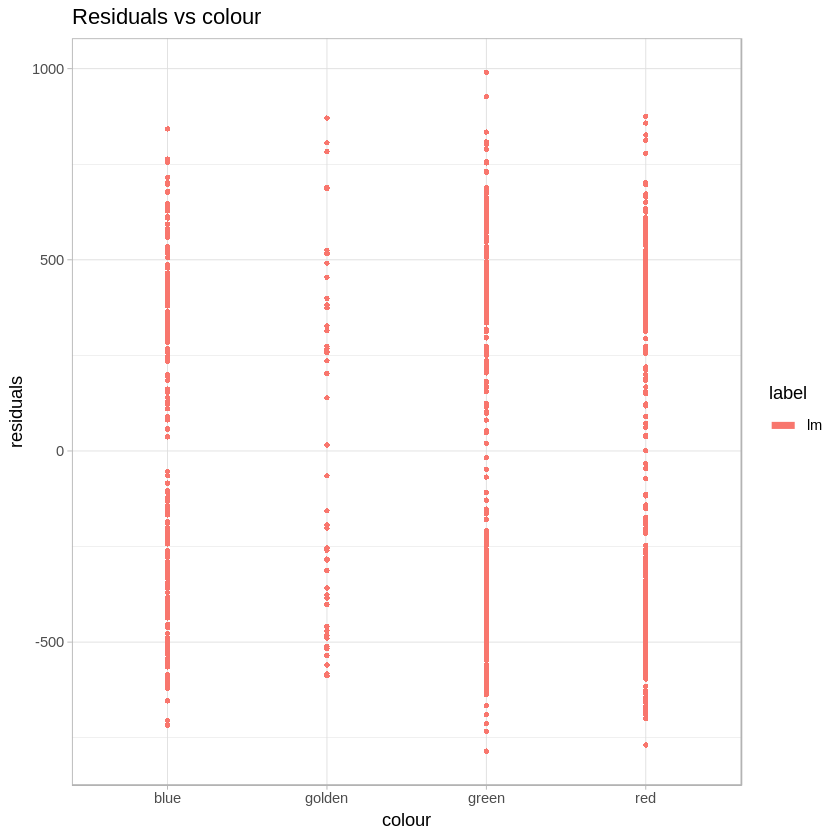

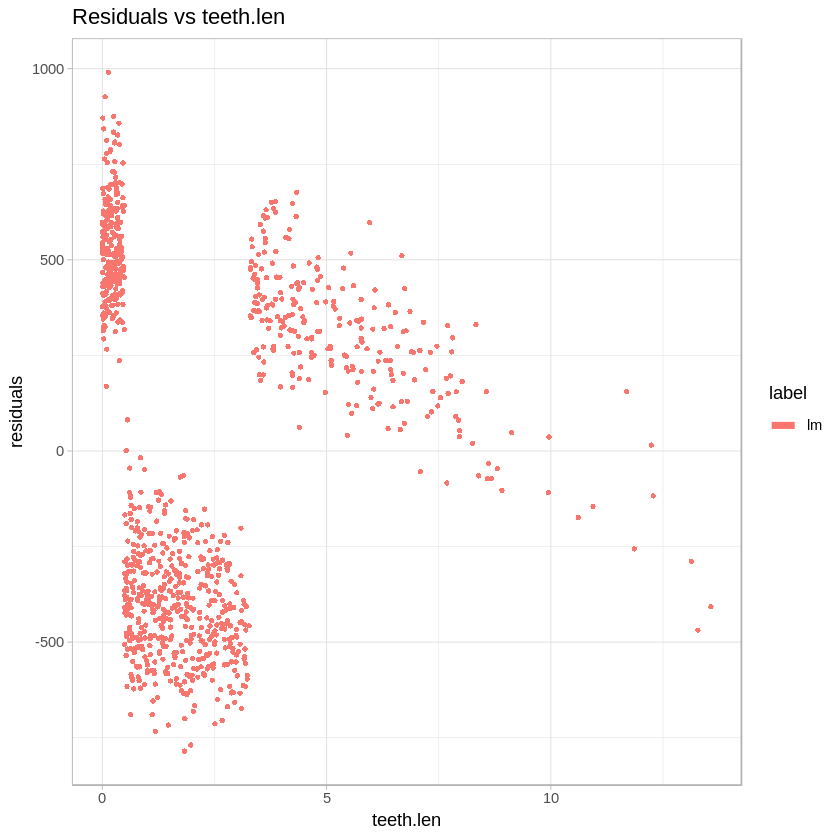

In [13]:
plotResidual(lm_audit, variable = 'herd.size')
plotResidual(lm_audit, variable = 'height')
plotResidual(lm_audit, variable = 'colour')
plotResidual(lm_audit, variable = 'teeth.len')

We can see clearly, that the residualschange drastically with `teeth.len`. Let's try to replace `teeth.len` with a new variable `teeth.q` which indicates in which quartile the value is.

In [14]:
dragons$teeth.q <- ifelse(dragons$teeth.len < quantile(dragons$teeth.len, .25), '0', 
                          ifelse(dragons$teeth.len < quantile(dragons$teeth.len, .50), '1', 
                                 ifelse(dragons$teeth.len < quantile(dragons$teeth.len, .75), '2', '3')))

dragons_test$teeth.q <- ifelse(dragons_test$teeth.len < quantile(dragons_test$teeth.len, .25), '0', 
                               ifelse(dragons_test$teeth.len < quantile(dragons_test$teeth.len, .50), '1', 
                                 ifelse(dragons_test$teeth.len < quantile(dragons_test$teeth.len, .75), '2', '3')))

## New models

Now, we can fit new models on that variable.

In [15]:
lm_model <- lm(life.len ~ height + colour + herd.size + teeth.q, data=dragons)

In [16]:
library("rpart")
set.seed(59)
tree_model <- rpart(life.len ~ height + colour + herd.size + teeth.q, data=dragons)

In [18]:
lm_audit <- audit(lm_model, label = "lm", data = dragons_test, y = dragons_test$life.len)
tree_audit <- audit(tree_model, label = "tree", data = dragons_test, y = dragons_test$life.len)

In [19]:
lm_mp <- modelPerformance(lm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
tree_mp <- modelPerformance(tree_audit, scores = c("MAE", "MSE", "REC", "RROC"))

First, let's see how the residual density looks like.

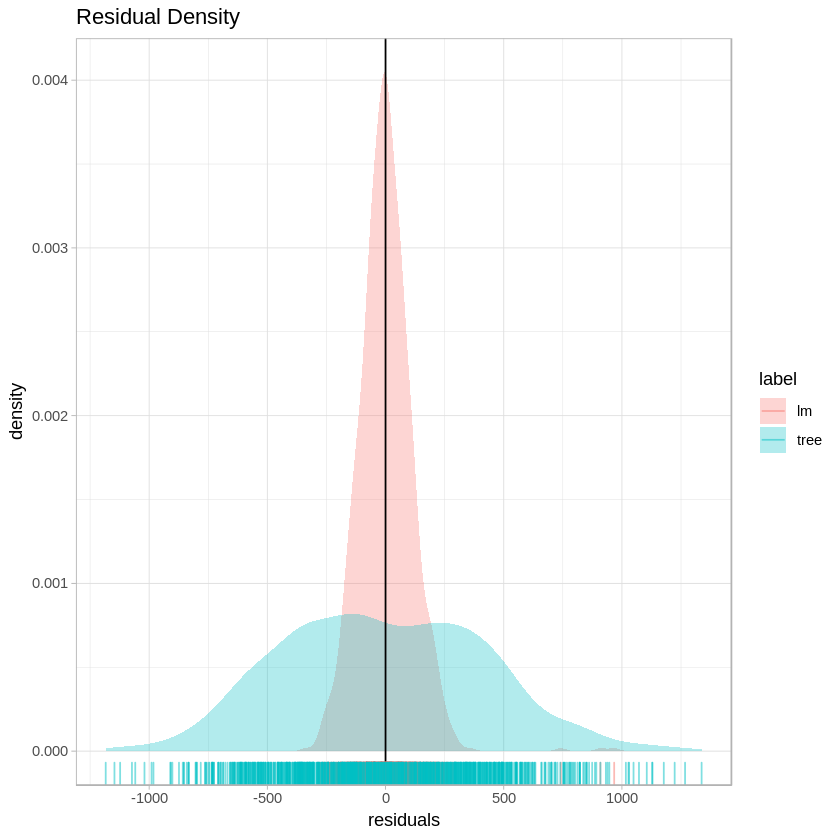

In [20]:
plotResidualDensity(lm_audit, tree_audit)

Much better. Now the residuals against `teeth.len`. No correlation can be seen now.

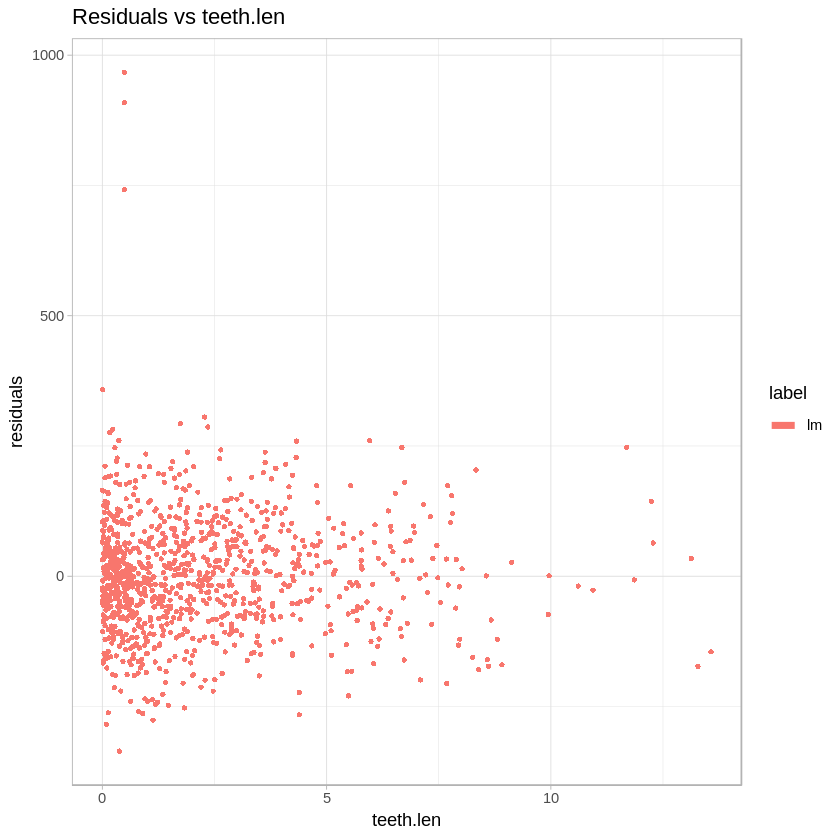

In [22]:
plotResidual(lm_audit, variable = 'teeth.len')

Let's check the performance og the models.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


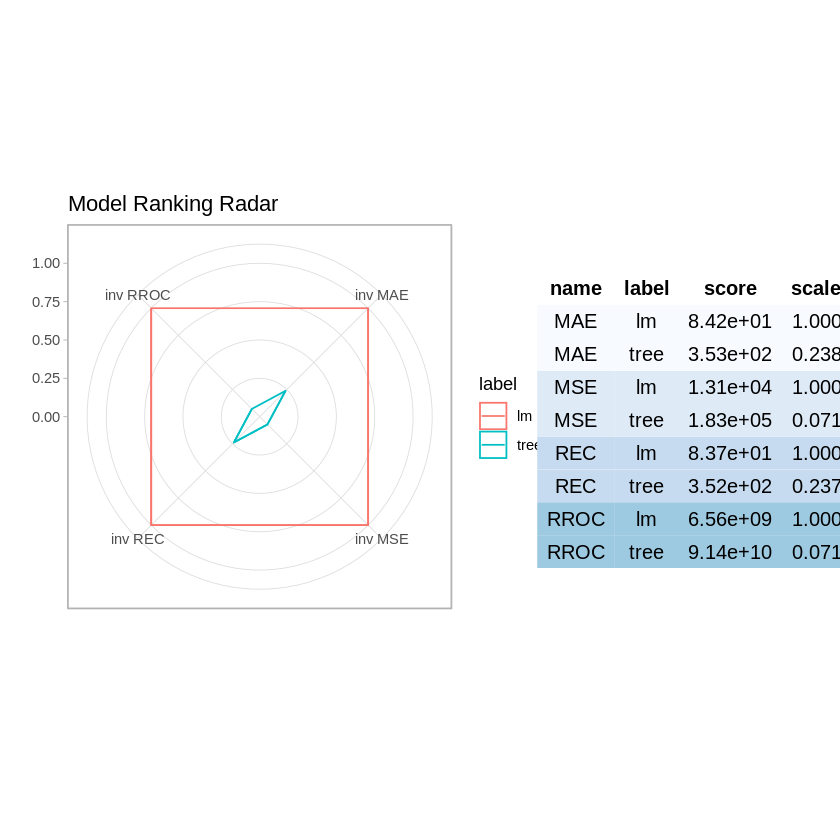

In [23]:
plot(lm_mp, tree_mp, table = TRUE)

Now the linear model is much better than it was before changing the variable. We were able to tweak the performance of the model by closely looking at residuals.